In [1]:
# Import necessary libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.path as mpath

In [2]:
year = 1980
data = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(year)).isel(time = slice(100,200))
data = data.load()


In [3]:
## only label landfalling AR
data['Y'] = xr.where(data.Y.isin([1100, 1101, 1110, 1111]),1, 0) 

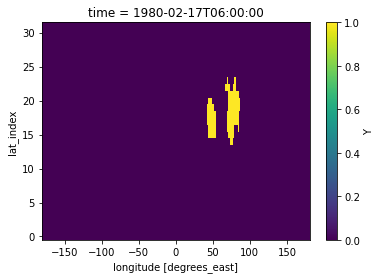

In [4]:
data.isel(time = 89).Y.plot()

In [5]:
#load maps
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',edgecolor='lightblue',facecolor='white') # 10m, 50m, 110m # edgecolor lightblue
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='none',facecolor='none') # 10m, 50m, 110m
ice_shelf_poly = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',edgecolor='none',facecolor='white') # 10m, 50m, 110m
ice_shelf_line = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',edgecolor='black',facecolor='none') # 10m, 50m, 110m

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
basins = basins.Zwallybasins > 0


In [6]:
# slice_start = np.array([0, 30, 60, 90, 120, 150, -180, -150, -120, -90, -60, -30])
slice_start = np.array([0, 36, 72, 108, 144, -180 ,-144, -108, -72,-36])

slice_end = slice_start + 36
colors = ['red', 'orange','yellow', 'green','blue', 'indigo', 'hotpink', 
          'red', 'orange','yellow', 'green','blue', 'indigo', 'hotpink',
         'red', 'orange','yellow', 'green','blue', 'indigo', 'hotpink']

/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


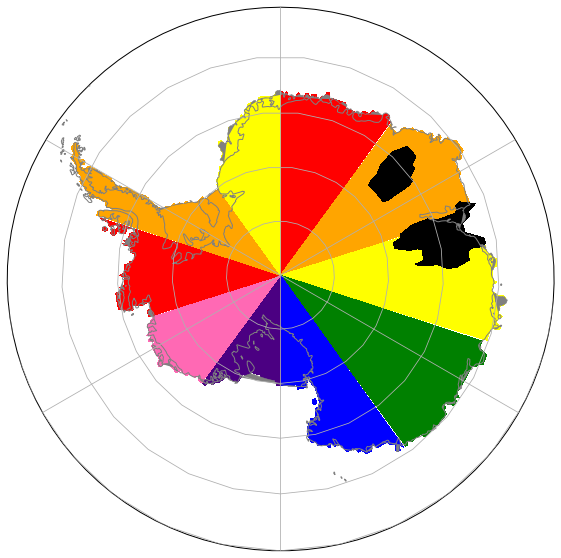

In [7]:
fig, ax=plt.subplots(ncols=1,nrows=1,figsize=(10,10),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})


ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
grid=ax.gridlines(zorder = 20)
grid.n_steps=30

for s in range(len(slice_start)):
    slice_data = basins.sel(lon  = slice(slice_start[s], slice_end[s]))
    ax.contourf(slice_data.lon, slice_data.lat, slice_data.values ,cmap = ListedColormap(['none', colors[s]]), transform=ccrs.PlateCarree())

ax.contourf(data.lon, data.lat, data.isel(time = 89).Y,cmap = ListedColormap(['none', 'black']), transform=ccrs.PlateCarree())
    
ax.coastlines(resolution='50m', color = 'grey',linewidth = 1,zorder = 11)
ax.add_feature(ice_shelf_line, color = 'grey', linewidth = .5,zorder = 11)


In [14]:
list_results = []
for s in range(len(slice_start)):
    list_results.append(data.sel(lon = slice(slice_start[s], slice_end[s])).Y.sum(dim = ('lat_index','lon')))

In [34]:
ar_data = np.vstack(list_results)
Y_data = np.zeros((np.shape(ar_data)[1]))
for t in range(np.shape(ar_data)[1]):
    if np.max(ar_data[:,t]) !=0:
        Y_data[t] = (np.argmax(ar_data[:,t])+1)

In [36]:
## Y_data is the slice of Antarctica that the max number of AR pixels lie in. 
## Now make this for all X data and make a new trining dataset with these categories